# Exploritory Data Analysis

This file will take all the EDA performed by the team and made to run self contained on files from the GitHub repo.

### Contents
1. High Level Look At The Datasets
    1. Client Supplied Datasets For Temperature And Demand
    2. Solar PV Data
    3. Population Data
    4. Rain Data
2. Dataset Interactions
    1. A Closer Look At Demand Over Time
    2. Demand With Weather And Datetime Data
    3. Multivariate Analysis


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import dateutil.easter as ea
from statsmodels.tsa.seasonal import MSTL
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

pd.plotting.register_matplotlib_converters()
%matplotlib inline
sns.set_theme()

## High Level Look At The Datasets
### Client Supplied Datasets for Temperature and Demand
Here we will load in the client supplied datasets for temperature and demand and have a look at the overall structure of the data.

In [2]:
# Load in client datasets
temp_df = pd.read_csv('../data/raw/temperature_nsw.csv', names=['datetime', 'location', 'temp'], header=0)
temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])
demand_df = pd.read_csv('../data/raw/totaldemand_nsw.csv', names=['datetime', 'region', 'demand'], header=0)
demand_df['datetime'] = pd.to_datetime(demand_df['datetime'])

First, let's look at the temperature dataset

In [3]:
print(f'Number of null cells: {temp_df["temp"].isnull().sum()}')
print(temp_df.head(-1))
print(temp_df.describe())

Number of null cells: 0
                  datetime  location  temp
0      2010-01-01 00:00:00   94766.0  23.1
1      2010-01-01 00:01:00   94766.0  23.1
2      2010-01-01 00:30:00   94766.0  22.9
3      2010-01-01 00:50:00   94766.0  22.7
4      2010-01-01 01:00:00   94766.0  22.6
...                    ...       ...   ...
247640 2022-07-31 21:30:00   94766.0  14.0
247641 2022-07-31 22:00:00   94766.0  14.0
247642 2022-07-31 22:30:00   94766.0  13.2
247643 2022-07-31 23:00:00   94766.0  13.3
247644 2022-07-31 23:30:00   94766.0  12.7

[247645 rows x 3 columns]
       location           temp
count  247646.0  247646.000000
mean    94766.0      16.518476
std         0.0      87.923650
min     94766.0   -9999.000000
25%     94766.0      13.300000
50%     94766.0      17.600000
75%     94766.0      21.200000
max     94766.0      44.700000


We can see there is likely some record or sensor issue causing -9999 values. Let's have a look at the boxplot to see if we need to remove any other values.

<Axes: >

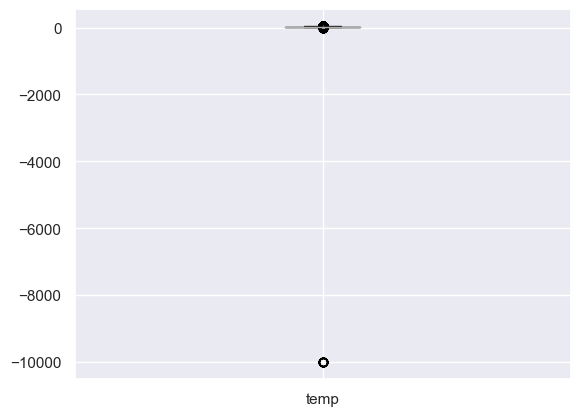

In [4]:
temp_df.boxplot('temp')

Looks like it is just the -9999 values that will need to be removed.

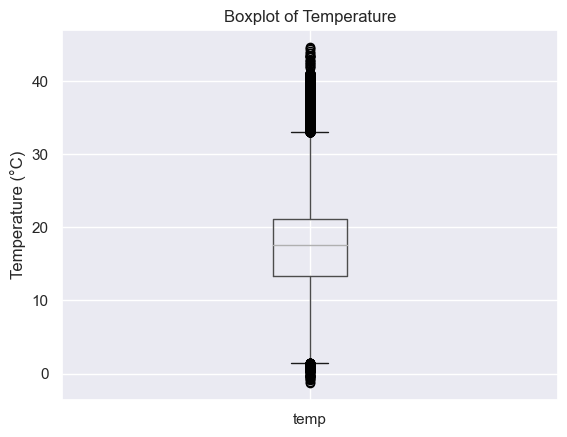

In [5]:
temp_df = temp_df[temp_df['temp'] > -9999]
# Recreate boxplot with problem values removed
ax = temp_df.boxplot('temp')
plt.title('Boxplot of Temperature')
plt.ylabel('Temperature (°C)')
plt.savefig('../images/exploratory/temperature-boxplot.png')

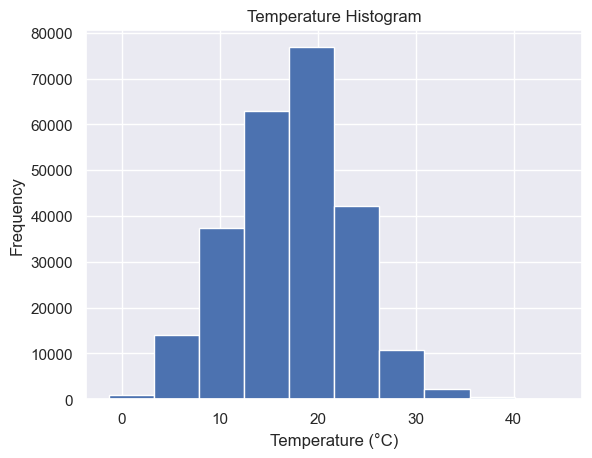

In [6]:
ax = temp_df.hist('temp')
plt.title('Temperature Histogram')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.savefig('../images/exploratory/temperature-histogram.png')

Temperature records seem to follow a fairly normal trend.
Let's now have a look at the timings of when records were made to look for irregularities in the dataset

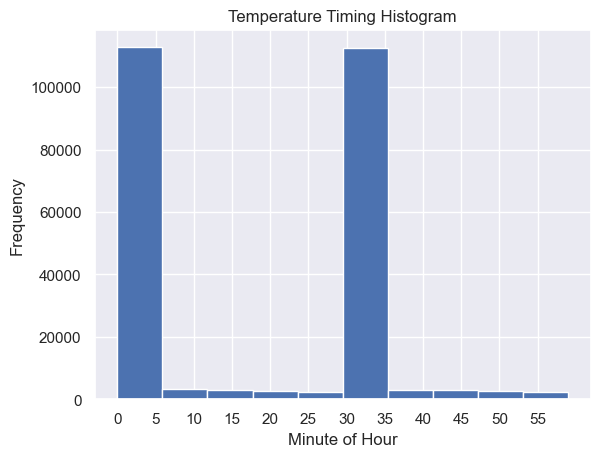

In [7]:
plt.hist(x=temp_df['datetime'].dt.minute)
plt.title('Temperature Timing Histogram')
plt.xlabel('Minute of Hour')
plt.ylabel('Frequency')
plt.xticks(np.arange(0,60,step=5))
plt.savefig('../images/exploratory/temperature-timing-histogram.png')

We can see there may be some irregularities in the way the data was recoded but for the purposes of our analysis, this should not raise any issues.

Let's now have a similar look at the demand dataset.

In [8]:
print(f'Number of null cells: {demand_df["demand"].isnull().sum()}')
print(demand_df.head(-1))
print(demand_df.describe())

Number of null cells: 0
                   datetime region   demand
0       2010-01-01 00:00:00   NSW1  7997.41
1       2010-01-01 00:05:00   NSW1  7946.51
2       2010-01-01 00:10:00   NSW1  7921.55
3       2010-01-01 00:15:00   NSW1  7837.84
4       2010-01-01 00:20:00   NSW1  7781.11
...                     ...    ...      ...
1323392 2022-07-31 23:35:00   NSW1  8275.87
1323393 2022-07-31 23:40:00   NSW1  8180.34
1323394 2022-07-31 23:45:00   NSW1  8237.50
1323395 2022-07-31 23:50:00   NSW1  8109.83
1323396 2022-07-31 23:55:00   NSW1  8044.52

[1323397 rows x 3 columns]
             demand
count  1.323398e+06
mean   8.067966e+03
std    1.308206e+03
min    4.286190e+03
25%    7.097480e+03
50%    7.996510e+03
75%    8.914310e+03
max    1.464883e+04


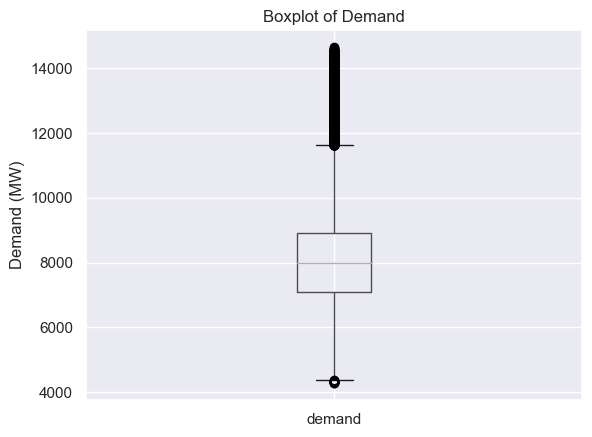

In [9]:
ax = demand_df.boxplot('demand')
plt.title('Boxplot of Demand')
plt.ylabel('Demand (MW)')
plt.savefig('../images/exploratory/demand-boxplot.png')

We can see that the base load in demand is fairly consistent around 4000kW, were as there is much more variation and larger peaks in the maximum demand.

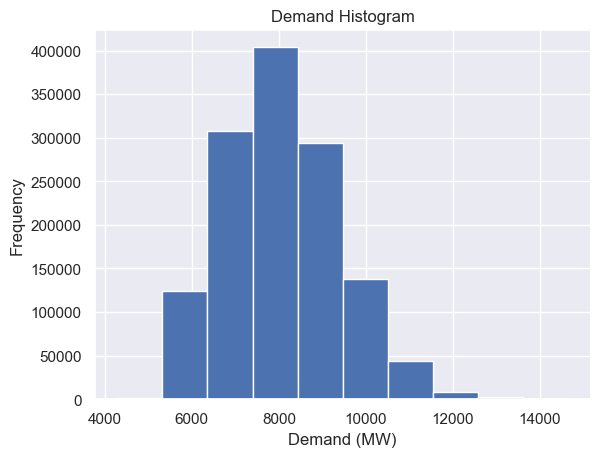

In [10]:
ax = demand_df.hist('demand')
plt.title('Demand Histogram')
plt.xlabel('Demand (MW)')
plt.ylabel('Frequency')
plt.savefig('../images/exploratory/demand-histogram.png')

The histogram shows a similar skew to the data as the boxplot.
Again, let's have a look at the timings of when data was collected.

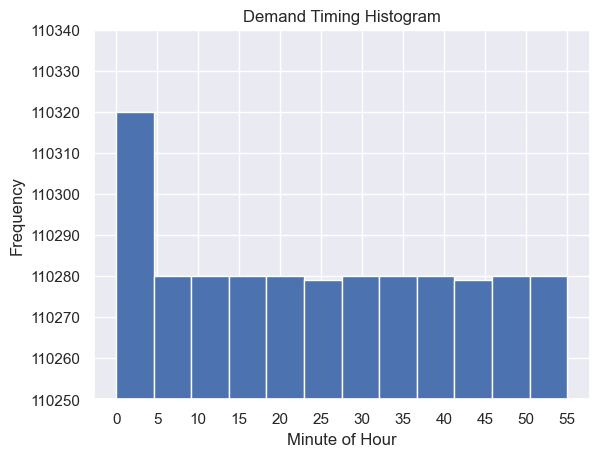

In [11]:
plt.hist(x=demand_df['datetime'].dt.minute, bins=12)
plt.xticks(np.arange(0,60,step=5))
plt.ylim([110250, 110340])
plt.title('Demand Timing Histogram')
plt.xlabel('Minute of Hour')
plt.ylabel('Frequency')
plt.savefig('../images/exploratory/demand-timing-histogram.png')

Again, we can see some irregularities in how data was recorded, with more records being made on the hour, though for the purposes of our analysis it should not matter.
Let's have a quick look at how demand has changed year-on-year.

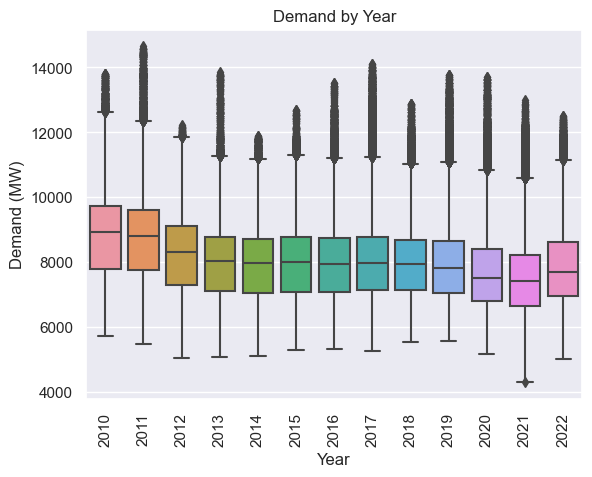

In [12]:
demand_df['year'] = demand_df.datetime.dt.year
ax = sns.boxplot(data=demand_df, x='year', y='demand')
plt.title('Demand by Year')
plt.xlabel('Year')
plt.ylabel('Demand (MW)')
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.savefig('../images/exploratory/demand-by-year.png')

It looks like there may be a downward trend in demand, though it is difficult to say.

### Solar PV Data
We are interested in how residential, or small-scale, solar panels affect demand in NSW. Let's bring in some data from the Clean Energy Regulator (CER) and have a look at it. The data is spread across numerous .xlsx files that have data for all states so it will need to be filtered and combined before we can look at it.

In [13]:
# Supress a waring from openpyxl
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
# Load in data from first workbook as starting point for df
# named solar08_df as we will only end up taking the 2008 data from this df
solar08_df = pd.read_excel('../data/raw/Postcode data for small-scale installations 2009 - all data.xlsx',
                           sheet_name='SGU-Solar', header=2)
solar08_df.head(-1)

,Small Unit Installation Postcode,Previous Years (2001-2007) - Installations Quantity,Previous Years (2001-2007) - SGU Rated Output In kW,Jan 2008 - Installations Quantity,Jan 2008 - SGU Rated Output In kW,Feb 2008 - Installations Quantity,Feb 2008 - SGU Rated Output In kW,Mar 2008 - Installations Quantity,Mar 2008 - SGU Rated Output In kW,Apr 2008 - Installations Quantity,...,Sep 2009 - Installations Quantity,Sep 2009 - SGU Rated Output In kW,Oct 2009 - Installations Quantity,Oct 2009 - SGU Rated Output In kW,Nov 2009 - Installations Quantity,Nov 2009 - SGU Rated Output In kW,Dec 2009 - Installations Quantity,Dec 2009 - SGU Rated Output In kW,Installations Quantity Total,SGU Rated Output In kW Total
0,0,4,4.46,0,0.00,0,0.0,0,0.0,0,...,0,0.00,0,0.0,0,0.0,0,0.00,4,4.46
1,200,1,0.08,0,0.00,0,0.0,0,0.0,0,...,0,0.00,0,0.0,0,0.0,0,0.00,1,0.08
2,800,3,19.36,2,4.16,0,0.0,0,0.0,0,...,0,0.00,0,0.0,0,0.0,0,0.00,7,34.74
3,801,2,3.44,0,0.00,0,0.0,0,0.0,0,...,0,0.00,0,0.0,0,0.0,0,0.00,2,3.44
4,803,0,0.00,0,0.00,0,0.0,0,0.0,0,...,0,0.00,0,0.0,0,0.0,0,0.00,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,7468,0,0.00,0,0.00,0,0.0,0,0.0,0,...,0,0.00,0,0.0,0,0.0,0,0.00,0,0.00
2790,7469,0,0.00,0,0.00,0,0.0,0,0.0,0,...,1,1.05,0,0.0,0,0.0,0,0.00,1,1.05
2791,7470,0,0.00,0,0.00,0,0.0,0,0.0,0,...,1,1.02,0,0.0,0,0.0,0,0.00,1,1.02
2792,7802,0,0.00,0,0.00,0,0.0,0,0.0,0,...,0,0.00,0,0.0,0,0.0,1,2.45,1,2.45


In [14]:
# Create a function for filtering for NSW postcodes only i.e. 2XXX
def nsw_mask(df):
    mask = (df['Small Unit Installation Postcode'] >= 2000) & (df['Small Unit Installation Postcode'] < 3000)
    return mask

In [15]:
# Filter out unnecessary locations
mask08 = nsw_mask(solar08_df)
nsw08_df = solar08_df.loc[mask08]

# Get the initial data from prior to 2008
INITIAL_SOLARUNITS = nsw08_df.sum()['Previous Years (2001-2007) - Installations Quantity']
INITIAL_SOLARPOWER = nsw08_df.sum()['Previous Years (2001-2007) - SGU Rated Output In kW']

# Get total number of units added in usable format
solar_units = nsw08_df.filter(regex='2008 - Installations Quantity', axis=1).sum()
solar_units.index = ['Jan 2008', 'Feb 2008', 'Mar 2008', 'Apr 2008', 'May 2008', 'Jun 2008',
                     'Jul 2008', 'Aug 2008', 'Sep 2008', 'Oct 2008', 'Nov 2008', 'Dec 2008']
solar_units.index = pd.to_datetime(solar_units.index)

# Do the same for power added
solar_output = nsw08_df.filter(regex='2008 - SGU Rated Output In kW', axis=1).sum()
solar_output.index = ['Jan 2008', 'Feb 2008', 'Mar 2008', 'Apr 2008', 'May 2008', 'Jun 2008',
                      'Jul 2008', 'Aug 2008', 'Sep 2008', 'Oct 2008', 'Nov 2008', 'Dec 2008']
solar_output.index = pd.to_datetime(solar_output.index)

In [16]:
# Add data from other workbooks
months = ['Jan ', 'Feb ', 'Mar ', 'Apr ', 'May ', 'Jun ',
          'Jul ', 'Aug ', 'Sep ', 'Oct ', 'Nov ', 'Dec ']

# Loop through all the years we have solar data for and add the data to df
for year in range(2009, 2021):
    df = pd.read_excel('../data/raw/Postcode data for small-scale installations ' + str(year) + ' - all data.xlsx',
                       sheet_name=0, header=2)
    # filter by NSW data only
    loc_mask = nsw_mask(df)
    df = df.loc[loc_mask]
    # separate Quantity and Output
    df_units = df.filter(regex= str(year) + ' - Installations Quantity', axis=1).sum()
    df_output = df.filter(regex= str(year) + ' - SGU Rated Output In kW', axis=1).sum()
    # Reset index to datetime
    month_year = []
    for month in months:
        month_year.append(month + str(year))
    df_units.index = month_year
    df_units.index = pd.to_datetime(df_units.index)
    df_output.index = month_year
    df_output.index = pd.to_datetime(df_output.index)
    # Append to end of dataframe
    solar_units = pd.concat([solar_units, df_units])
    solar_output = pd.concat([solar_output, df_output])

# Build usable dataset for export
cum_solar_units = solar_units.cumsum() + INITIAL_SOLARUNITS
cum_solar_output = solar_output.cumsum() + INITIAL_SOLARPOWER

solar_df = pd.concat([solar_units, cum_solar_units, solar_output, cum_solar_output], axis=1)
solar_df.rename(columns={0:'solar units added', 1:'cumulative units added', 2:'solar output added', 3:'cumulative output added'}, inplace=True)
solar_df.index.names = ['datetime']

In [17]:
solar_df.head()

,solar units added,cumulative units added,solar output added,cumulative output added
datetime,,,,
2008-01-01,127,1882.0,287.946,2710.745
2008-02-01,172,2054.0,258.114,2968.859
2008-03-01,192,2246.0,294.417,3263.276
2008-04-01,183,2429.0,303.252,3566.528
2008-05-01,233,2662.0,339.387,3905.915


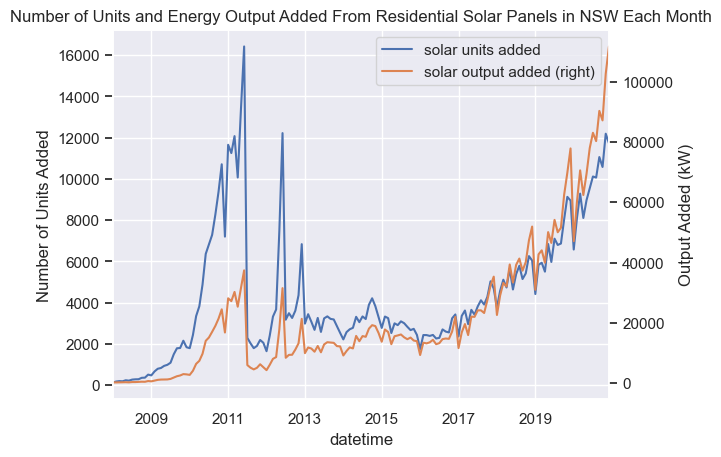

In [18]:
ax = solar_df['solar units added'].plot(ylabel='Number of Units Added', legend=True)
solar_df['solar output added'].plot(ax=ax, secondary_y=True, ylabel='Output Added (kW)', legend=True)
plt.title('Number of Units and Energy Output Added From Residential Solar Panels in NSW Each Month')
plt.xlabel('Year')
plt.savefig('../images/exploratory/units-output-plot.png')

We can see that the number of units being added in the 2010-2012 period is quite high, which may be due to government schemes, rebates, or even some change in they way the recording was being done in that time. As we will most likely be interested in the cumulative effects of solar, this will likely have little affect on our modelling.
It is also worth noting that the Output being added per unit is increasing, meaning the technology is getting more efficient.

Now let's look at the cumulative values that we are more interested in.

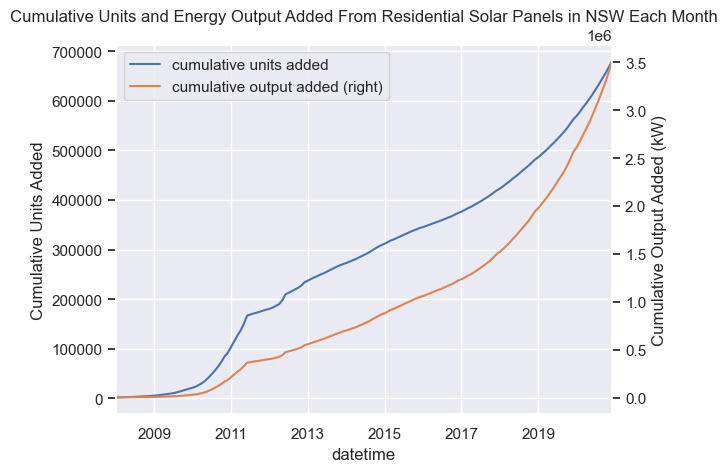

In [19]:
ax = solar_df['cumulative units added'].plot(ylabel='Cumulative Units Added', legend=True)
solar_df['cumulative output added'].plot(ax=ax, secondary_y=True, ylabel='Cumulative Output Added (kW)', legend=True)
plt.title('Cumulative Units and Energy Output Added From Residential Solar Panels in NSW Each Month')
plt.xlabel('Year')
plt.savefig('../images/exploratory/cumulative-units-output-plot.png')

We can see that the large spike in units and output added in the 2010-2012 period is still noticeable, but less impactful in the cumulative output that we will likely be the most interested in.
It's worth noting that this graph shows a similar trend in output growing faster than the units being added, but both look like the are growing at an increasing rate since the large addition in the 2010-2012 period.

### Population Data
Population will likely play a role in the demand. Let's bring in population data from the Australian Bureau of Statistics (ABS). The ABS data goes from 2001-2021 and is yearly.

In [20]:
# Import population data
pop_df = pd.read_csv('../data/raw/NSW_population.csv', usecols=['TIME_PERIOD: Time Period', 'OBS_VALUE'], header=0)
pop_df.rename(columns={'TIME_PERIOD: Time Period':'datetime', 'OBS_VALUE':'population'}, inplace=True)
pop_df['datetime'] = pd.to_datetime(pop_df['datetime'], format='%Y')
pop_df.set_index('datetime', inplace=True)
pop_df.head(21)

,population
datetime,
2001-01-01,6530349
2002-01-01,6580807
2003-01-01,6620715
2004-01-01,6650735
2005-01-01,6693206
2006-01-01,6742690
2007-01-01,6834156
2008-01-01,6943461
2009-01-01,7053755


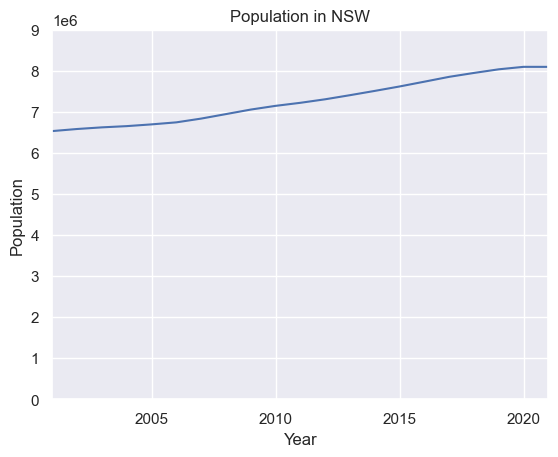

In [21]:
pop_df['population'].plot(title='Population in NSW', xlabel='Year', ylabel='Population', ylim=[0, 9e6])
plt.savefig('../images/exploratory/NSW-population.png')

We can see that population grows at a relatively steady rate. It is worth noting that 2021 had negative growth compared to all previous years, which were closer to 1%. This may be due to a correction to estimates from the census data. It will need to be considered when modelling and future forecasting, but these are likely the best estimates available.

### Rain Data
As we are interested in the effects of residential solar on the grid demand, we would like to incorporate cloud coverage data. As we don't have that we will use daily precipitation data from weather stations in areas with a lot of solar output as a proxy to see if it has an effect on grid demand due to changing residential solar output.

First, we will take some data from the Australian PV Institute to find regions by postcode that have high solar output.

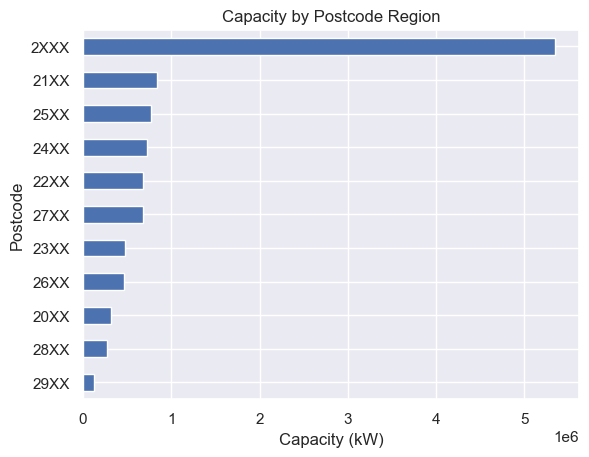

In [22]:
postcode_pv_df = pd.read_csv('../data/raw/Postcode time series.csv')
postcode_df_sum = postcode_pv_df.groupby('Postcode').agg('sum', numeric_only=True)
ax = postcode_df_sum.sort_values('Capacity (kW)').plot(kind='barh', title='Capacity by Postcode Region', legend=False, xlabel='Capacity (kW)')
plt.savefig('../images/exploratory/output-by-postcode.png')

From the results above, the 21XX postcodes have the highest PV installation capacity. From this [map](https://pv-map.apvi.org.au/historical#9/-33.9115/150.5814), we can see that 21XX postcodes are the suburbs near the Sydney CBD.

Now, we find the [BoM weather stations](http://www.bom.gov.au/nsw/observations/sydneymap.shtml) that are located in the 21XX suburbs, which are:

*   PARRAMATTA NORTH (MASONS DRIVE), 066124
*   KIAMA (BOMBO HEADLAND), 068242
*   SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE), 066212
*   CANTERBURY RACECOURSE AWS, 066194
*   HORSLEY PARK EQUESTRIAN CENTRE AWS, 067119
*   PROSPECT RESERVOIR, 067019

The daily rain data is then extracted from those stations ([link](http://www.bom.gov.au/climate/data/)), and then we extract the data from 01/01/2010 onwards.

In [23]:
weather_station_ids = ['066124', '068242', '066212', '066194', '067119', '067019']

# Get all data from weather stations
for n in range(len(weather_station_ids)):
    file_name = 'IDCJAC0009_' + weather_station_ids[n] + '_1800_Data.csv'

    # Create new dataframe
    if n == 0:
        bom_df = pd.read_csv('../data/raw/' + file_name)
        bom_df = bom_df.drop(columns=['Product code', 'Period over which rainfall was measured (days)', 'Quality'])
        bom_df = bom_df[bom_df['Year'] >= 2010]
        bom_df['Rainfall amount (millimetres)'] = bom_df['Rainfall amount (millimetres)'].fillna(0)

    # Add to existing dataframe
    else:
        df = pd.read_csv('../data/raw/' + file_name)
        df = df.drop(columns=['Product code', 'Period over which rainfall was measured (days)', 'Quality'])
        df = df[df['Year'] >= 2010]
        df['Rainfall amount (millimetres)'] = df['Rainfall amount (millimetres)'].fillna(0)
        bom_df = pd.concat([bom_df, df], ignore_index=True)

In [24]:
# Create a single datetime column
bom_df['datetime'] = pd.to_datetime(bom_df['Year'].astype(str) + '-' + bom_df['Month'].astype(str) + '-' + bom_df['Day'].astype(str))
bom_df['datetime'] = pd.to_datetime(bom_df['datetime'])
# Get the total amount of rain for all weather stations for each day
rain_df = bom_df.groupby(["datetime"])["Rainfall amount (millimetres)"].sum().to_frame()
rain_df.head()

,Rainfall amount (millimetres)
datetime,
2010-01-01,0.0
2010-01-02,0.8
2010-01-03,58.4
2010-01-04,7.2
2010-01-05,0.4


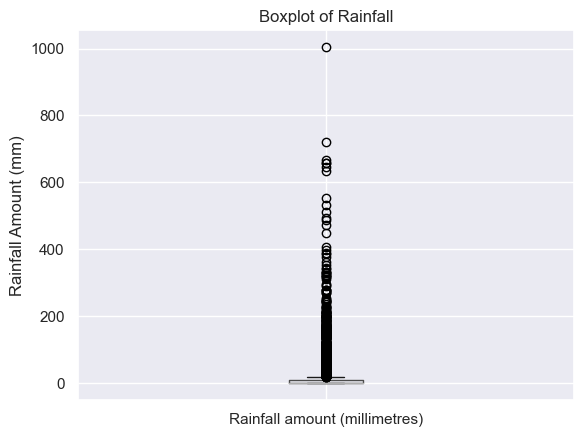

In [25]:
ax = rain_df.boxplot('Rainfall amount (millimetres)')
plt.title('Boxplot of Rainfall')
plt.ylabel('Rainfall Amount (mm)')
plt.savefig('../images/exploratory/rain-boxplot.png')

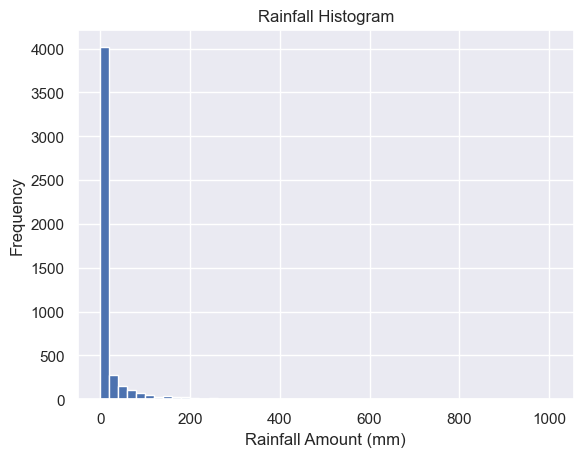

In [26]:
ax = rain_df.hist('Rainfall amount (millimetres)', bins=50)
plt.title('Rainfall Histogram')
plt.xlabel('Rainfall Amount (mm)')
plt.ylabel('Frequency')
plt.savefig('../images/exploratory/rain-histogram.png')

From the histogram and boxplot, we can see that this is a very skewed dataset. Most values are 0 or close to with some very large outliers. This data may not be very useful for our model.

## Looking At Dataset Interactions
We are now going to combine the proposed datasets and look at the interactions between some of the potential predictors in the model. We are interested in looking at how daily maximum and minimum demand changes over time, this will require some interpolation of data that are on different time scales, namely the solar_df and pop_df.
As these data change at a relatively steady rate over the timescales that we will be interpolating, we will assume that a simple linear interpolation will suffice.

We will also add in some predictors based on the date to see if date factors influence demand, such as weekends and public holidays.


In [27]:
# Get daily min and max demand
demand_df = demand_df.resample('D', on='datetime')['demand'].agg(['min', 'max'])
demand_df.rename(columns={'min':'demand_min', 'max':'demand_max'}, inplace=True)

# Get daily min and max temperatures
temp_df = temp_df.resample('D', on='datetime')['temp'].agg(['min', 'max'])
temp_df.rename(columns={'min':'temp_min', 'max':'temp_max', 'mean':'temp_mean'}, inplace=True)

# Interpolate solar data but remove the amount of units added in a month
solar_df.drop(['solar units added', 'solar output added'], axis=1, inplace=True)
solar_df.rename(columns={'cumulative units added': 'cum_units', 'cumulative output added': 'cum_output'}, inplace=True)
solar_df = solar_df.resample('D', convention='end').interpolate(method='linear')

# Interpolate population data
pop_df = pop_df.resample('D', convention='start').interpolate(method='linear')

# Rename rainfall for simplicity
rain_df.rename(columns={'Rainfall amount (millimetres)': 'rain'}, inplace=True)

In [28]:
# Merge all data into one dataframe
all_data = demand_df.merge(temp_df, on='datetime', how='outer')
all_data = all_data.merge(solar_df, on='datetime', how='outer')
all_data = all_data.merge(pop_df, on='datetime', how='outer')
all_data = all_data.merge(rain_df, on='datetime', how='outer')
all_data.sort_index(inplace=True)
all_data.head()

,demand_min,demand_max,temp_min,temp_max,cum_units,cum_output,population,rain
datetime,,,,,,,,
2001-01-01,NaN,NaN,NaN,NaN,NaN,NaN,6.530349e+06,NaN
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,6.530487e+06,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,6.530625e+06,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,6.530764e+06,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,6.530902e+06,NaN


We have sections that have large chunks of data missing so they wil have to be filtered out.

In [29]:
bounds_mask = (all_data.index >= '2010-01-01') & (all_data.index < '2020-12-01')
all_data = all_data[bounds_mask]
all_data.head(-1)

# There are still some dates with missing temperature
all_data = all_data.dropna()

Let's now add in our date time features.

In [30]:
def create_date_predictors(dataframe):
    """Function to create datetime features from a datetime index"""
    df = dataframe.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

In [31]:
def public_holiday_check(new_date_check):
    """Function for finding public holidays in NSW"""
    new_date = pd.Timestamp(new_date_check)
    # New Year and Australia Day
    if new_date.month == 1:
        if new_date.weekday() not in (5,6):
            if new_date.day in (1,26):
                return 1
        elif new_date.weekday() == 5:
            if new_date.day in (3,28):
                return 1
        else:
            if new_date.day in (2,27):
                return 1
    if new_date.month == 3 & ea.easter(new_date.year).month ==3:
        if new_date.day in range(ea.easter(new_date.year).day-2,ea.easter(new_date.year).day+1):
            return 1
    # Anzac day
    if new_date.month == 4:
        if new_date.weekday() not in (5,6):
            if new_date.day == 25:
                return 1
        elif new_date.weekday() == 6:
            if new_date.day == 26:
                return 1
        else:
            if new_date.day == 27:
                return 1
        if ea.easter(new_date.year).month == 4:
            if new_date.day in range(ea.easter(new_date.year).day-2,ea.easter(new_date.year).day+1):
                return 1
    # king/queen birthday
    if new_date.month == 6 & new_date.day > 7 & new_date.day < 15 & new_date.weekday() == 0:
        return 1
    # Labour day
    if new_date.month == 10 & new_date.day < 8 & new_date.weekday() == 0:
        return 1
    # Christmas and boxing day
    if new_date.month == 12:
        if new_date.weekday() not in (5,6):
            if new_date.day in (25,26):
                return 1
        elif new_date.weekday() == 5:
            if new_date.day in (27,28):
                return 1
        else:
            if new_date.day in (26,27):
                return 1
    return 0

In [32]:
# Add in datetime predictors
all_data = create_date_predictors(all_data)
all_data['public_holiday'] = all_data.index.to_frame()['datetime'].apply(lambda x: public_holiday_check(x))
all_data.head()

,demand_min,demand_max,temp_min,temp_max,cum_units,cum_output,population,rain,dayofweek,month,year,dayofyear,dayofmonth,public_holiday
datetime,,,,,,,,,,,,,,
2010-01-01,6157.36,8922.42,22.1,28.8,21518.000000,30362.926000,7.144292e+06,0.0,4,1,2010,1,1,1
2010-01-02,6112.73,9326.64,21.6,29.4,21596.419355,30496.336935,7.144495e+06,0.8,5,1,2010,2,2,0
2010-01-03,6014.91,8277.85,17.9,21.5,21674.838710,30629.747871,7.144699e+06,58.4,6,1,2010,3,3,0
2010-01-04,6023.79,9522.30,17.9,23.9,21753.258065,30763.158806,7.144902e+06,7.2,0,1,2010,4,4,0
2010-01-05,6287.12,10728.72,15.4,27.7,21831.677419,30896.569742,7.145106e+06,0.4,1,1,2010,5,5,0


OK, we now have a dataframe with all our proposed predictors. Let's have a closer look at some of the interactions.

### A Closer Look At Demand Over Time
We saw previously that there may be a downward trend in demand, let's have a closer look at the demand when you are just looking at the minimum and maximum demand for a day.

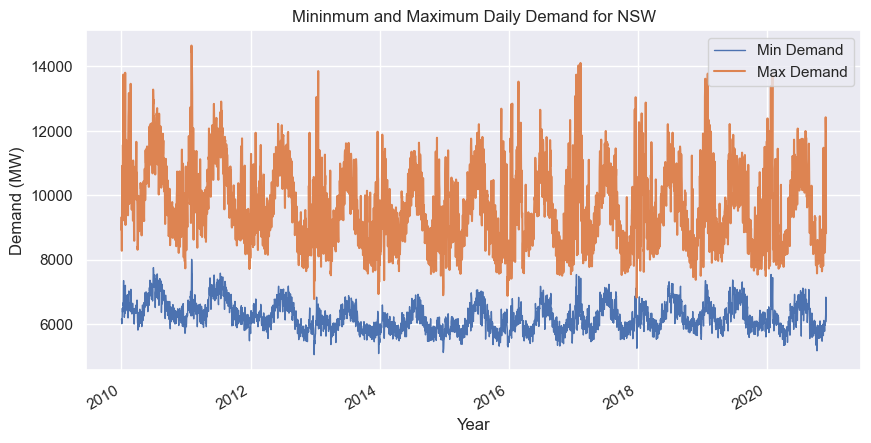

In [33]:
ax = all_data['demand_min'].plot(figsize=(10,5), ms=1, lw=1, ylabel='Demand (MW)', title='Mininmum and Maximum Daily Demand for NSW')
all_data['demand_max'].plot(ax=ax)
plt.xlabel('Year')
plt.legend(['Min Demand', 'Max Demand'], loc='upper right')
plt.savefig('../images/exploratory/min-max-demand.png')

It is quite difficult in this plot to see the overall trend in the data.
We will now do a timeseries decomposition to remove the noise and look at the trend. We won't tune the decomposition too much as we just want to get an idea of the broad trend.

In [34]:
# Use MSTL from the statsmodels package to do multiple decomposition
mstl_max = MSTL(all_data['demand_max'], periods=[7, 365])
res_max = mstl_max.fit()

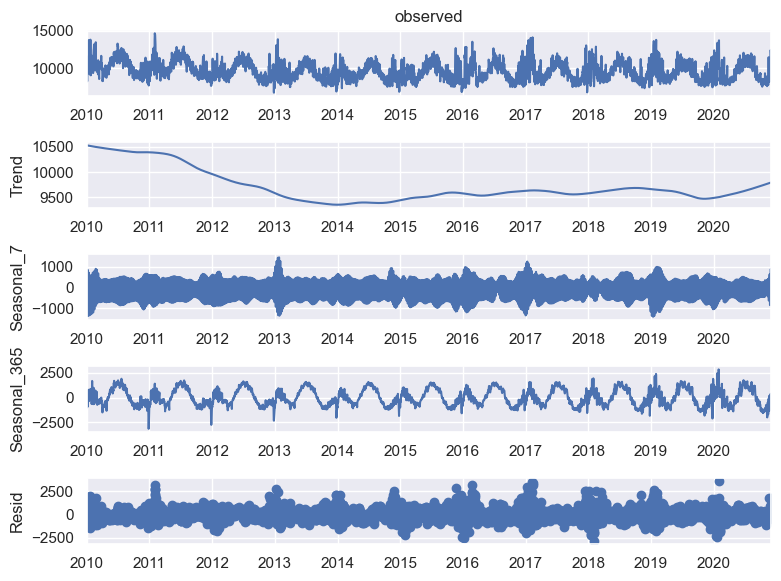

In [35]:
plt.rc("figure", figsize=(8, 6))
plt.rc("font", size=13)
fig = res_max.plot()
fig.savefig('../images/exploratory/max-decomp.png')

In [36]:
# Now do the same with the min demand
mstl_min = MSTL(all_data['demand_min'], periods=[7, 365])
res_min = mstl_min.fit()

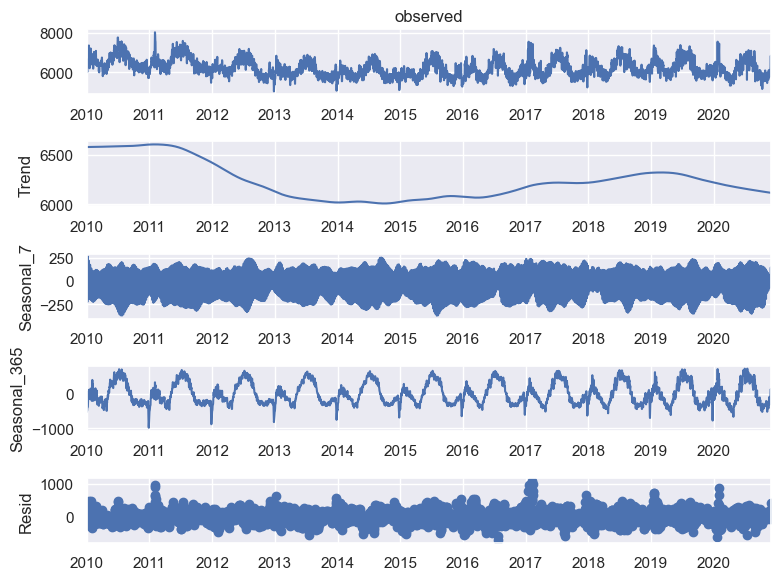

In [37]:
fig = res_min.plot()
fig.savefig('../images/exploratory/min-decomp.png')

It does look like there is a downward trend in both minimum and maximum demand, especially in the 2011-2014 period.

### Demand With Weather And Datetime Data
Let's now see if there are relationships between weather, datetime, and demand.

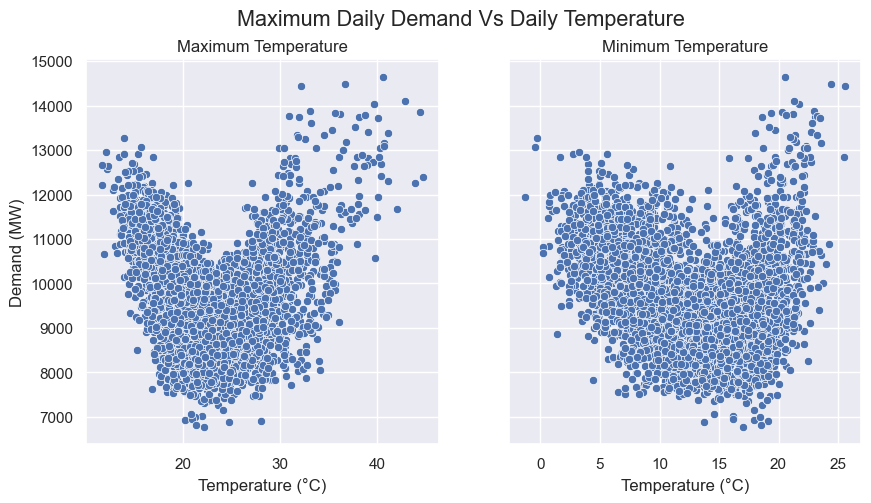

In [38]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.scatterplot(data=all_data, x='temp_max', y='demand_max', ax=ax[0])
ax[0].set_xlabel('Temperature (°C)')
ax[0].set_title('Maximum Temperature')
sns.scatterplot(data=all_data, x='temp_min', y='demand_max', ax=ax[1])
ax[1].set_xlabel('Temperature (°C)')
ax[1].set_title('Minimum Temperature')
ax[0].set_ylabel('Demand (MW)')
fig.suptitle('Maximum Daily Demand Vs Daily Temperature')
plt.savefig('../images/exploratory/max-demand-temp.png')

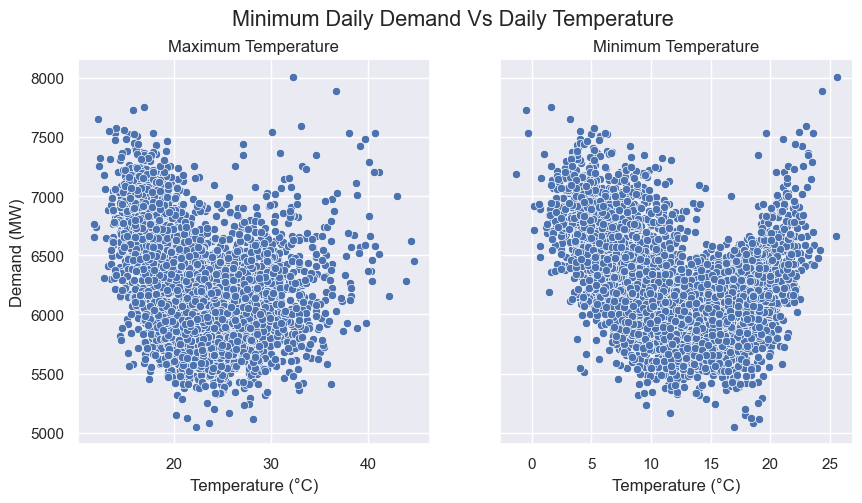

In [39]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.scatterplot(data=all_data, x='temp_max', y='demand_min', ax=ax[0])
ax[0].set_xlabel('Temperature (°C)')
ax[0].set_title('Maximum Temperature')
sns.scatterplot(data=all_data, x='temp_min', y='demand_min', ax=ax[1])
ax[1].set_xlabel('Temperature (°C)')
ax[1].set_title('Minimum Temperature')
ax[0].set_ylabel('Demand (MW)')
fig.suptitle('Minimum Daily Demand Vs Daily Temperature')
plt.savefig('../images/exploratory/min-demand-temp.png')

The maximum demand plotted against maximum temperature seems to have the most structure in the data. Minimum daily temperature with both minimum and maximum demand appear to have similar amounts of structure to the data. Maximum temperature with minimum demand appears to have the least strong relationship.

Now let's do the same plots but with colour for days of week and public holidays to see if we can account for some of the outliers.

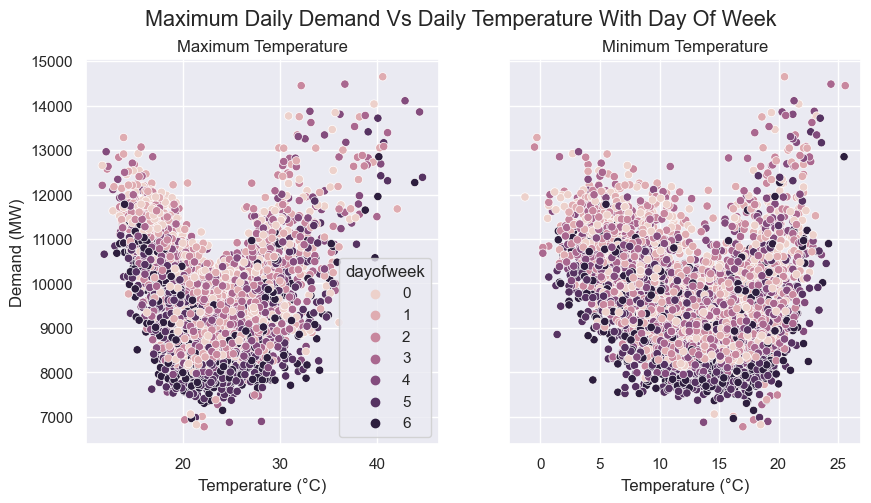

In [40]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.scatterplot(data=all_data, x='temp_max', y='demand_max', hue='dayofweek', ax=ax[0])
ax[0].set_xlabel('Temperature (°C)')
ax[0].set_title('Maximum Temperature')
sns.scatterplot(data=all_data, x='temp_min', y='demand_max', hue='dayofweek', ax=ax[1], legend=False)
ax[1].set_xlabel('Temperature (°C)')
ax[1].set_title('Minimum Temperature')
ax[0].set_ylabel('Demand (MW)')
fig.suptitle('Maximum Daily Demand Vs Daily Temperature With Day Of Week')
plt.savefig('../images/exploratory/max-demand-temp-dayweek.png')

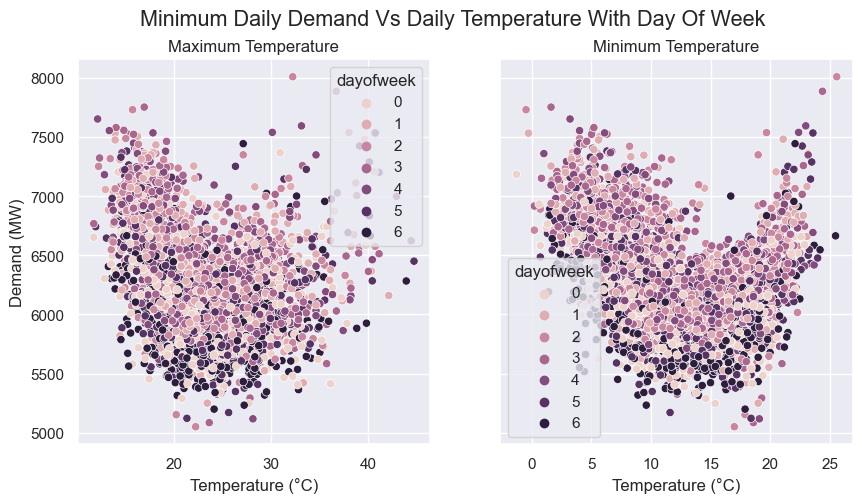

In [41]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.scatterplot(data=all_data, x='temp_max', y='demand_min', hue='dayofweek', ax=ax[0])
ax[0].set_xlabel('Temperature (°C)')
ax[0].set_title('Maximum Temperature')
sns.scatterplot(data=all_data, x='temp_min', y='demand_min', hue='dayofweek', ax=ax[1])
ax[1].set_xlabel('Temperature (°C)')
ax[1].set_title('Minimum Temperature')
ax[0].set_ylabel('Demand (MW)')
fig.suptitle('Minimum Daily Demand Vs Daily Temperature With Day Of Week')
plt.savefig('../images/exploratory/min-demand-temp-dayweek.png')

It looks like the maximum daily demand is highly dependent on the day of the week, with Saturdays (5) and Sundays (6) tending to have lower demand than weekdays (0-4).
The minimum daily demand shows less dependency on the day of the week, but it still looks to be a factor.

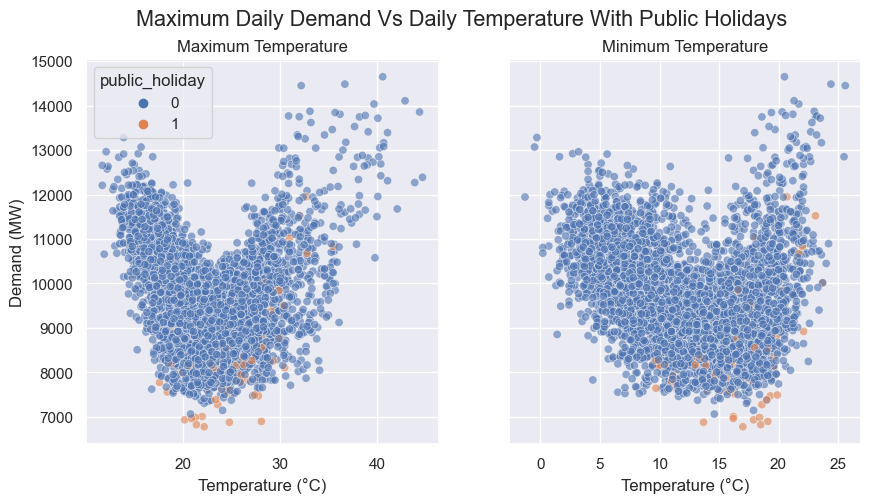

In [42]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.scatterplot(data=all_data, x='temp_max', y='demand_max', hue='public_holiday', alpha=0.6, ax=ax[0])
ax[0].set_xlabel('Temperature (°C)')
ax[0].set_title('Maximum Temperature')
sns.scatterplot(data=all_data, x='temp_min', y='demand_max', hue='public_holiday', alpha=0.6, ax=ax[1], legend=False)
ax[1].set_xlabel('Temperature (°C)')
ax[1].set_title('Minimum Temperature')
ax[0].set_ylabel('Demand (MW)')
fig.suptitle('Maximum Daily Demand Vs Daily Temperature With Public Holidays')
plt.savefig('../images/exploratory/max-demand-temp-pubhol.png')

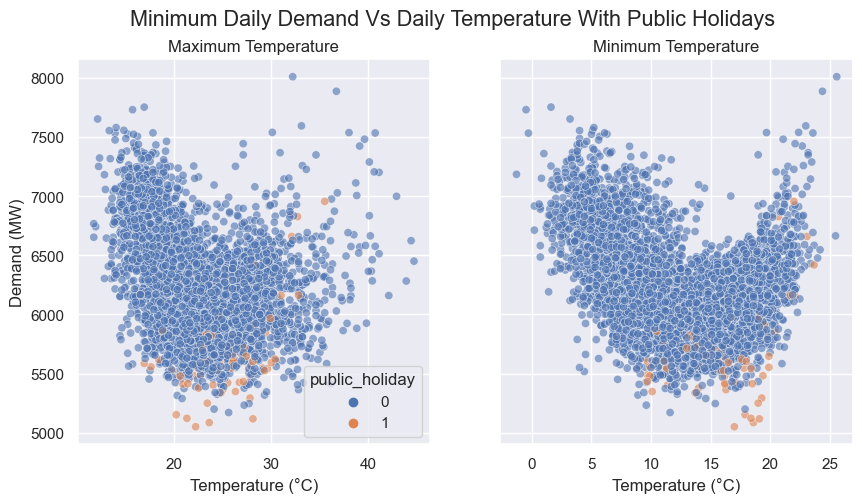

In [43]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.scatterplot(data=all_data, x='temp_max', y='demand_min', hue='public_holiday', alpha=0.6, ax=ax[0])
ax[0].set_xlabel('Temperature (°C)')
ax[0].set_title('Maximum Temperature')
sns.scatterplot(data=all_data, x='temp_min', y='demand_min', hue='public_holiday', alpha=0.6, ax=ax[1], legend=False)
ax[1].set_xlabel('Temperature (°C)')
ax[1].set_title('Minimum Temperature')
ax[0].set_ylabel('Demand (MW)')
fig.suptitle('Minimum Daily Demand Vs Daily Temperature With Public Holidays')
plt.savefig('../images/exploratory/min-demand-temp-pubhol.png')

It looks like Public Holidays have a similar effect as weekends.

Now let's see if the rain data has an effect. There are a lot of days that have no rain, the structure might be more visible if we filter out days that got less than 5mm of rain.

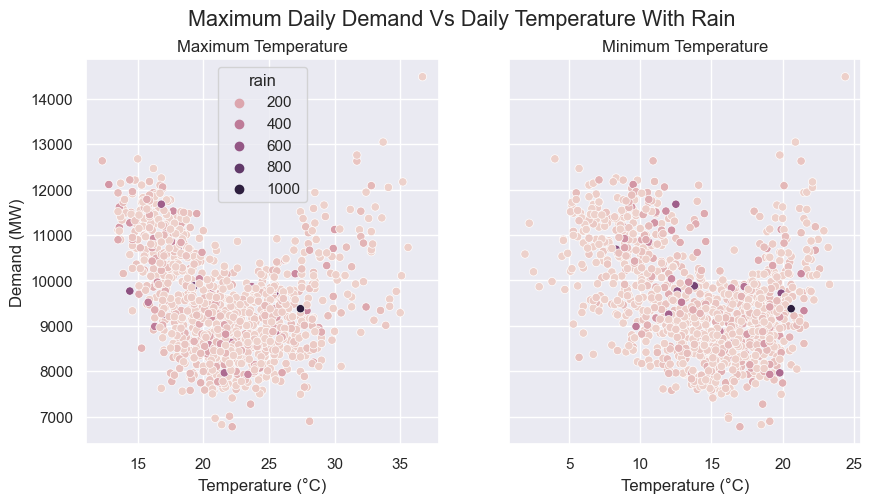

In [44]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.scatterplot(data=all_data[all_data['rain'] > 5], x='temp_max', y='demand_max', hue='rain', ax=ax[0])
ax[0].set_xlabel('Temperature (°C)')
ax[0].set_title('Maximum Temperature')
sns.scatterplot(data=all_data[all_data['rain'] > 5], x='temp_min', y='demand_max', hue='rain', ax=ax[1], legend=False)
ax[1].set_xlabel('Temperature (°C)')
ax[1].set_title('Minimum Temperature')
ax[0].set_ylabel('Demand (MW)')
fig.suptitle('Maximum Daily Demand Vs Daily Temperature With Rain')
plt.savefig('../images/exploratory/max-demand-temp-rain.png')

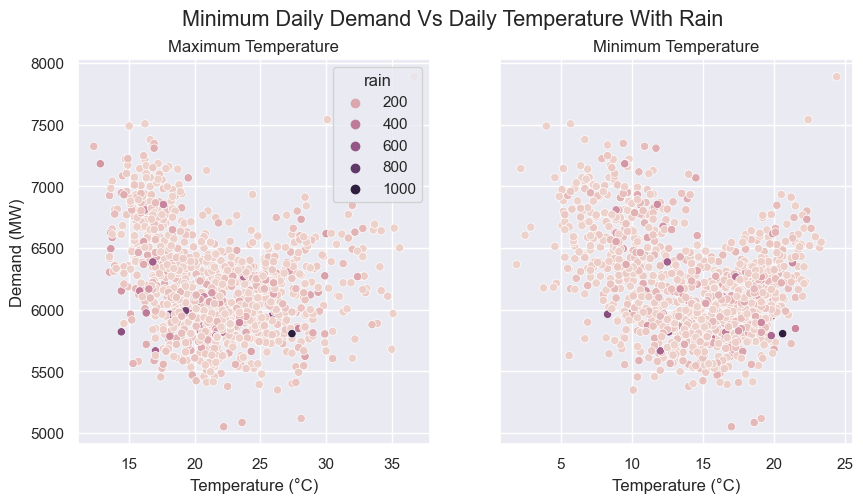

In [45]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.scatterplot(data=all_data[all_data['rain'] > 5], x='temp_max', y='demand_min', hue='rain', ax=ax[0])
ax[0].set_xlabel('Temperature (°C)')
ax[0].set_title('Maximum Temperature')
sns.scatterplot(data=all_data[all_data['rain'] > 5], x='temp_min', y='demand_min', hue='rain', ax=ax[1], legend=False)
ax[1].set_xlabel('Temperature (°C)')
ax[1].set_title('Minimum Temperature')
ax[0].set_ylabel('Demand (MW)')
fig.suptitle('Minimum Daily Demand Vs Daily Temperature With Rain')
plt.savefig('../images/exploratory/min-demand-temp-rain.png')

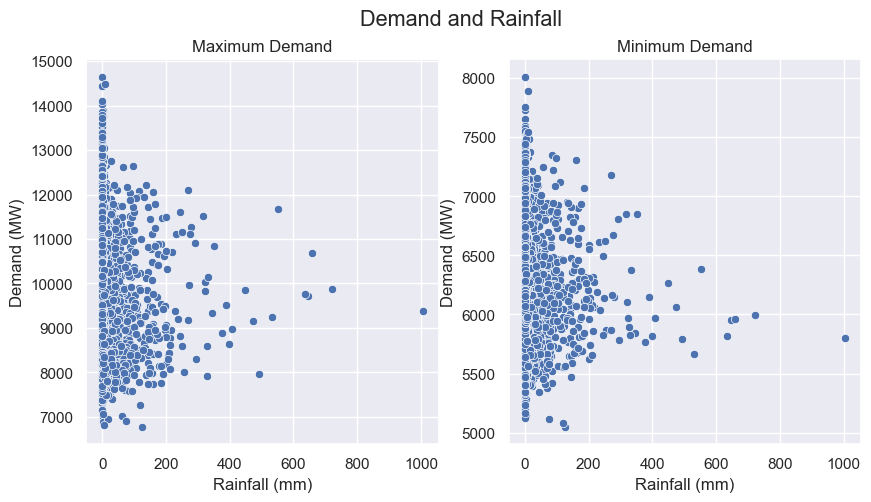

In [46]:
fig, ax = plt.subplots(1,2, sharey=False, figsize=(10,5))
sns.scatterplot(data=all_data, x='rain', y='demand_max', ax=ax[0])
sns.scatterplot(data=all_data, x='rain', y='demand_min', ax=ax[1])
ax[0].set_xlabel('Rainfall (mm)')
ax[0].set_title('Maximum Demand')
ax[0].set_ylabel('Demand (MW)')
ax[1].set_xlabel('Rainfall (mm)')
ax[1].set_title('Minimum Demand')
ax[1].set_ylabel('Demand (MW)')
fig.suptitle('Demand and Rainfall')
plt.savefig('../images/exploratory/demand-rain.png')

Looks like rain does not influence demand very much and may not be a good proxy for cloud cover if cloud cover does influence grid load. It may be that data from more weather stations would be needed to approximate cloud coverage.

### Multivariate Analysis
Now, let's have a look at how some of the features are linked by looking at the Canonical Correlation.

In [47]:
# Firstly scale the data for CCA
scaler = StandardScaler()
norm_data = scaler.fit_transform(all_data)
# Split into response and predictor data
y_data = norm_data[:,:2]
x_data = norm_data[:,2:]

In [48]:
# Canonical Correlation Analysis
ca = CCA()
X_c, Y_c = ca.fit_transform(x_data, y_data)

In [49]:
# Correlation between the first canonical pair
np.corrcoef(X_c[:,0], Y_c[:,0])[0,1]

0.6480881027965265

In [50]:
# Correlation between the second canonical pair
np.corrcoef(X_c[:,1], Y_c[:,1])[0,1]

0.4886706623703643

In [51]:
# Prepare dataframe for plotting heat map of correlations
ccX_df = pd.concat([all_data, pd.DataFrame({'CCX_1':X_c[:, 0], 'CCX_2':X_c[:, 1]}, index=all_data.index)], axis=1)

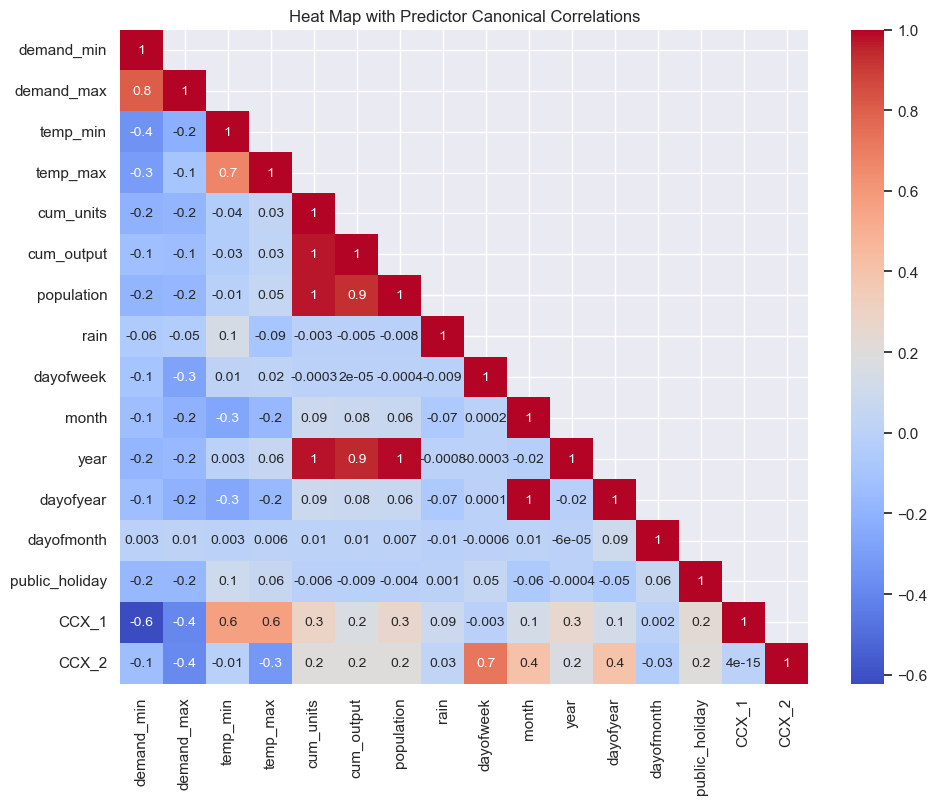

In [52]:
# Correlation between all fields , this will help analysis the relationship between the Transformed predictors and the responses
corr_X_df = ccX_df.corr(method='pearson')
plt.rc('font', size=10)
plt.figure(figsize=(10,8))
X_df_lt = corr_X_df.where(np.tril(np.ones(corr_X_df.shape)).astype(bool))
sns.heatmap(X_df_lt, cmap='coolwarm', annot=True, fmt='.1g')
plt.tight_layout()
plt.title('Heat Map with Predictor Canonical Correlations')
plt.savefig('../images/exploratory/heatmap-cca-preds.png')

In [53]:
# Prepare dataframe for plotting heat map of correlations
ccY_df = pd.concat([all_data, pd.DataFrame({'CCY_1':Y_c[:, 0], 'CCY_2':Y_c[:, 1]}, index=all_data.index)], axis=1)

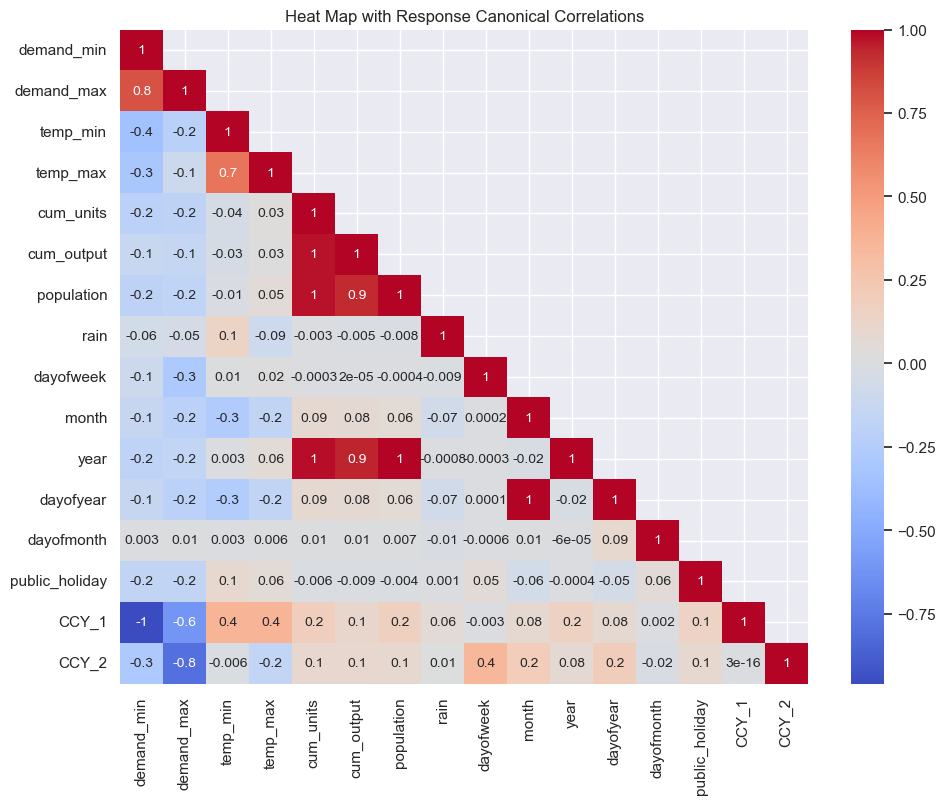

In [54]:
# Correlation between all fields, this will help analysis the relationship between the Transformed predictors and the responses
corr_Y_df = ccY_df.corr(method='pearson')
plt.rc('font', size=10)
plt.figure(figsize=(10,8))
Y_df_lt = corr_Y_df.where(np.tril(np.ones(corr_Y_df.shape)).astype(bool))
sns.heatmap(Y_df_lt, cmap='coolwarm', annot=True, fmt='.1g')
plt.tight_layout()
plt.title('Heat Map with Response Canonical Correlations')
plt.savefig('../images/exploratory/heatmap-cca-response.png')

We can see that there appears to be strong relationships between the temperature variables and the first canonical correlation, where as the date variables seem to be loading on the second canonical correlation; day of the week seems to have a strong influence, backing up what we saw earlier in the scatter plots. It seems that solar output and population may have some contributions to models, but it would be minor compared to temperature and datetime predictors.
Rain data still looks like it has little impact and can likely be dropped, as can day of the month.

It is also worth noting that there appears to be a high amount of correlation with some of our predictors, as is often the case with timeseries data. To mitigate this, cumulative units will be dropped. We may have to be mindful of how entangled population, year, and cumulative output are.

In [55]:
# Remove data that will not be needed for model building
all_data.drop(['cum_units', 'rain', 'dayofmonth'], axis=1, inplace=True)
all_data

,demand_min,demand_max,temp_min,temp_max,cum_output,population,dayofweek,month,year,dayofyear,public_holiday
datetime,,,,,,,,,,,
2010-01-01,6157.36,8922.42,22.1,28.8,3.036293e+04,7.144292e+06,4,1,2010,1,1
2010-01-02,6112.73,9326.64,21.6,29.4,3.049634e+04,7.144495e+06,5,1,2010,2,0
2010-01-03,6014.91,8277.85,17.9,21.5,3.062975e+04,7.144699e+06,6,1,2010,3,0
2010-01-04,6023.79,9522.30,17.9,23.9,3.076316e+04,7.144902e+06,0,1,2010,4,0
2010-01-05,6287.12,10728.72,15.4,27.7,3.089657e+04,7.145106e+06,1,1,2010,5,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,6051.38,10871.75,14.8,32.5,3.490182e+06,8.093864e+06,3,11,2020,331,0
2020-11-27,6152.19,10173.41,18.6,26.3,3.493903e+06,8.093863e+06,4,11,2020,332,0
2020-11-28,6284.18,12421.83,18.3,40.4,3.497624e+06,8.093862e+06,5,11,2020,333,0


In [56]:
# Output our clean data for modelling
all_data.to_csv('../data/processed/all_data.csv')